In [12]:
from data import Openwebtext

# Hyper-parameters
block_size = 1024
vocabulary_size = Openwebtext.VOCABULARY_SIZE
embedding_dimensions = 768
num_hidden_layers = 12

First, we'll estimate the total number of parameters in the network.

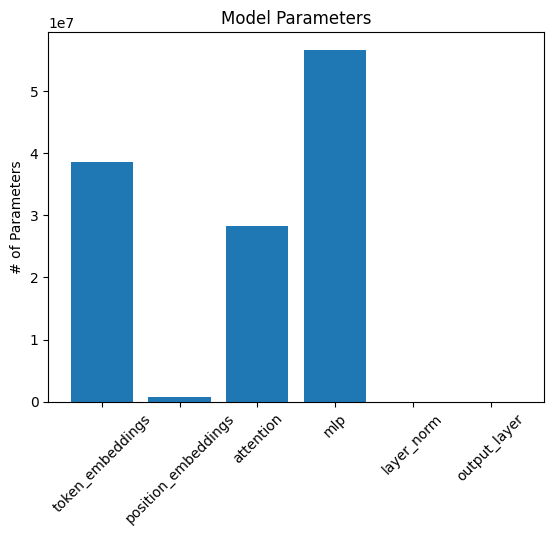

token_embeddings               38,597,376      31.04%
position_embeddings               786,432       0.63%
attention                      28,311,552      22.77%
mlp                            56,623,104      45.54%
layer_norm                         19,200       0.02%
output_layer                            0       0.00%


Total parameters: 124,337,664


In [13]:
import matplotlib.pyplot as plt

parameter_counts = {
    "token_embeddings": vocabulary_size * embedding_dimensions,
    "position_embeddings": block_size * embedding_dimensions,
    "attention": (embedding_dimensions ** 2 + embedding_dimensions * 3 * embedding_dimensions) * num_hidden_layers,
    "mlp": embedding_dimensions * 4 * embedding_dimensions * 2 * num_hidden_layers,
    "layer_norm": embedding_dimensions * num_hidden_layers * 2 + embedding_dimensions,
    "output_layer": 0, # Tied to token embeddings
}

plt.bar(parameter_counts.keys(), parameter_counts.values())

plt.title("Model Parameters")
plt.ylabel("# of Parameters")
plt.xticks(rotation=45)

plt.show()

total_parameter_count = sum(parameter_counts.values())

for name, count in parameter_counts.items():
    print(f"{name:20s} {count:20,d} {count / total_parameter_count * 100:10.2f}%")

print("\n")

print(f"Total parameters: {total_parameter_count:,}")

Next, we'll estimate the size of the model in memory and on disk. Note that this does not include any intermediate variables that get memorized during training such as activations and temporary buffers. Actual memory consumption will likely be much higher.

In [14]:
bytes_per_parameter = 32 // 8 # Assuming 32-bit floating point

buffers_per_parameter = 2 # Assuming AdamW optimizer

total_values = total_parameter_count + buffers_per_parameter * total_parameter_count

total_bytes_per_parameter = total_values * bytes_per_parameter

total_gigabytes = total_bytes_per_parameter / 1e9

print(f"Total gigabytes: {total_gigabytes:,.2f}")

Total gigabytes: 1.49


Next, we'll estimate the maximum number of floating point operations (FLOPs) required to perform a full forward pass of the network on a single sample.

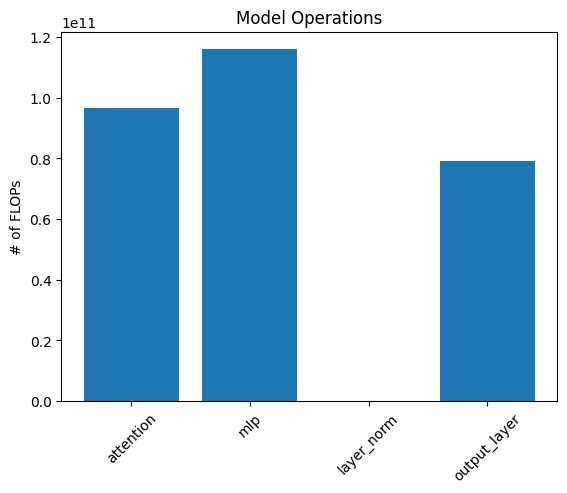

attention                  96,636,764,160      33.13%
mlp                       115,964,448,768      39.76%
layer_norm                         59,904       0.00%
output_layer               79,047,426,048      27.10%


Total forward FLOPs: 291,648,698,880


In [15]:
ops_per_matmul = 2 # Multiply + accumulate (MAC)
ops_per_activation = 9 # Assuming GELU
ops_per_layer_norm = 6 # Mean (1), variance (3), shift (1), scale (1)

# K, Q, V projections
attention = ops_per_matmul * block_size * embedding_dimensions * 3 * embedding_dimensions

# Attention logits
attention += 2 * ops_per_matmul * block_size ** 2 * embedding_dimensions

# Output projection
attention += ops_per_matmul * block_size * embedding_dimensions ** 2

attention *= num_hidden_layers

# Linear transformations
mlp = 2 * ops_per_matmul * block_size * embedding_dimensions * 4 * embedding_dimensions

# Non-linear activations
mlp += ops_per_activation * 4 * embedding_dimensions

mlp *= num_hidden_layers

layer_norm = ops_per_layer_norm * embedding_dimensions * (num_hidden_layers + 1)

output_layer = ops_per_matmul * block_size * embedding_dimensions * vocabulary_size

flops = {
    "attention": attention,
    "mlp": mlp,
    "layer_norm": layer_norm,
    "output_layer": output_layer,
}

plt.bar(flops.keys(), flops.values())

plt.title("Model Operations")
plt.ylabel("# of FLOPs")
plt.xticks(rotation=45)

plt.show()

total_forward_flops = sum(flops.values())

for name, count in flops.items():
    print(f"{name:20s} {count:20,d} {count / total_forward_flops * 100:10.2f}%")

print("\n")

print(f"Total forward FLOPs: {total_forward_flops:,}")

Next, we'll estimate the number of FLOPs for the backward pass. For this we use a simple heuristic of 2X the forward pass.

In [16]:
total_backward_flops = 2 * total_forward_flops

print(f"Total backward FLOPs: {total_backward_flops:,}")

Total backward FLOPs: 583,297,397,760


We'll do the same for the total FLOPs per roundtrip.

In [17]:
total_roundtrip_flops = total_forward_flops + total_backward_flops

print(f"Total roundtrip FLOPs: {total_roundtrip_flops:,}")

Total roundtrip FLOPs: 874,946,096,640


Now, let's estimate how long it would take to train over every sample in the Openwebtext training set at least once in expectation using a few well-known Nvidia GPUs as benchmarks. Note that these results shown here are a best-case scenario and neglect to factor in overhead such as moving data to and from VRAM.

In [18]:
RTX_A2000_BF16_FLOPS_PER_SECOND = 63.9e12
A100_SXM_BF16_FLOPS_PER_SECOND = 624.0e12
HGX_B100_BF16_FLOPS_PER_SECOND = 28000e12

num_training_tokens = 8994885755
samples_per_epoch = 4096

num_epochs_required = round(num_training_tokens / (samples_per_epoch * block_size))

print(f"Total tokens: {num_training_tokens:,}")
print(f"Epochs required: {num_epochs_required:,}", end="\n\n")

gpus = {
    "RTX A2000": RTX_A2000_BF16_FLOPS_PER_SECOND,
    "A100 SXM": A100_SXM_BF16_FLOPS_PER_SECOND,
    "HGX B100": HGX_B100_BF16_FLOPS_PER_SECOND,
}

for name, flops_per_second in gpus.items():
    seconds_per_epoch = samples_per_epoch * total_roundtrip_flops / flops_per_second

    days_required = num_epochs_required * seconds_per_epoch / 60 / 60 / 24

    print(f"{name}: {seconds_per_epoch:.2f} seconds/epoch, {days_required:,.2f} days required")

Total tokens: 8,994,885,755
Epochs required: 2,145

RTX A2000: 56.08 seconds/epoch, 1.39 days required
A100 SXM: 5.74 seconds/epoch, 0.14 days required
HGX B100: 0.13 seconds/epoch, 0.00 days required
